<a href="https://colab.research.google.com/github/mattsgithub/mattshomepage-articles/blob/main/articles/ann_viz.ipynb"><img src="https://raw.githubusercontent.com/mattsgithub/mattshomepage-articles/main/images/open_in_colab.svg" /></a>

Neural network classifiers must learn to linearly separate data. Why? When a sigmoid is used on the final layer, it's equivalent to a multinomial logistic regression problem. The features inputted to this model are learned by the network.

This observation makes makes you wonder when we make architectural choices such as ReLU, number of layers, etc. Are we making optimal choices that help the network achieve this?

I believe my first exposure to this idea was from one of <a href="https://colah.github.io/posts/2014-03-NN-Manifolds-Topology/">Colah's blog on neural networks and manifolds</a>. I have studied a few papers on this subject since then. One is on the <a href="https://arxiv.org/abs/2004.06093">Topology of Neural networks</a>. The paper hypothesizes that ReLU is a good activation function because its inverse is not always guaranteed (if the value inputted is <= 0, you get an output of 0--rendering the input irrecoverable).

Why does this matter? Well a set that perserves topological properties by definition must have an inverse. But if you think about: cutting manifolds is essential. That's how you are often able to detangle the mess of entangled classes.

Let me clear up what I mean by mainfold. I take the same view point as described in the <a href="https://www.nature.com/articles/s41467-020-14578-5">Separability and geometry of object manifolds in deep neural networks paper</a>. Take the problem of classifiying cats vs dogs images. Each training example can be plotted in feature space where each axis is a pixel value (a number between 0-255 when we assume a one-channel image). But for a given cat image, there are lots of small perturbations (as well as large changes) we can make. We could have the cat tilt its head ever so slightly. Or, have a different species of a cat. Collectively, the set of all possible variants are the "manifold" of this class. So they form a geometric object in this feature space. These geometric objects are what we are trying to linearly separate.

But IMHO, while topology (and in particular algebraic topology) is an interesting tool to apply, it does take a rather simplistic view of these manifolds. In practice, it seems topological equivalance is identified by holes. So a coffee mug and a donut are the same topologically, but I would think the details (such as curvature) are non-neglible to design a very good neural network.

Another <a href="https://arxiv.org/pdf/1802.04443.pdf">paper</a> I came across was from William Guss (now at OpenAI). The idea here was to compute some topological properties from the dataset and then use that to say something like "you will need at least 5 layers to solve this problem". That's the basic idea.

### ANIMATIONS
I think a fun place to start on this subject is to visualize what the hell happens when a neural network is detangling these manifolds. To explore this, I am sharing the following code.

This neural network only allows 2 nodes per layer (so we can visualize). If you wanted to use 4 or more nodes, you could try running something like PCA and plot the top two components.

I then make an animation of it as the neural network is learning. I constructed a few synthetic datasets, to see how the network behaves under different data distributions.

In [1]:
from collections import namedtuple
from random import shuffle

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(8)

This is code to generate synthetic datasets. I do not use the disk holes dataset in this blog, but feel free to use it. It's an implementation I did from the https://arxiv.org/abs/2004.06093 paper.

## Datasets

### HOLES DATASET

In [2]:
def get_disk_holes(r, r_hole, n_hole, allow_center=True):
    """
    Returns disks that are can be used to
    cut data from a disk of radius `r`
    """
    
    df = pd.DataFrame(columns=['r_hole', 'r', 'theta', 'x1', 'x2'])
    
    if n_hole < 1:
        return df
        
    n_non_center_holes = n_hole - allow_center
    
    df['theta'] = np.linspace(0, 2 * np.pi, num=n_non_center_holes, endpoint=False)
    df['r'] = [r / 2.] * n_non_center_holes
    df['x1'] = df.r * np.cos(df.theta)
    df['x2'] = df.r * np.sin(df.theta)
    
    # Special case for centered hole (undefined)
    if allow_center:
        center = {'r_hole': r_hole, 'r' : r / 2., 'theta': None, 'x1': 0, 'x2': 0}
        df = df.append(center, ignore_index=True)
    
    # Constants
    df['r_hole'] = r_hole
    df['r'] = r / 2.
               
    return df

def get_sample_from_disk(n, r):
    
    # Must take square root to get uniform
    # density across disk
    r = r * np.sqrt(np.random.random(size=n))
    
    theta = 2 * np.pi * np.random.random(size=len(r))
    
    df = pd.DataFrame()
    df['r'] = r
    df['theta'] = theta
    df['x1'] = df.r * np.cos(df.theta)
    df['x2'] = df.r * np.sin(df.theta)
        
    return df


def get_2d_holes_dataset(n_neg=500,
                         n_pos=500,
                         n_hole=9,
                         r=1.,
                         r_hole=.1,
                         r_pos=.02,
                         allow_center=True):
    """
    Generates a complex topological dataset
    consisting of two manifolds.
    
    Args
        n_neg: int
            How many negative examples to sample
            
        n_pos: int
            How many negative examples to sample
            
        n_hole: int
            Number of holes to generate
            
        r: float
            Radius of entire circle of which all data resides
            This is the disk from which negative examples
            are sampled from
            
        r_hole:
            Radius of hole(s)
            
        r_pos: float
            Radius of disks for positive examples
            
        allow_center: True
            If True, allow a hole to be created in the center
    """
    # First, perform data checks
    # We can't allow for example, r_hole > r
    r_hole_diameter = 2 * r_hole
    max_stacked_holes = 3
    holes_max_width = max_stacked_holes * r_hole_diameter
    if holes_max_width > r:
        raise ValueError(f'r_hole must be no more than r/6')
        
    if r_pos > r_hole:
        raise ValueError('r_pos cannot be greater than r_role')
        
    # Oversample. Will delete after
    # Need a smater approach instead of factor of 5 approach
    # Sampling will be proportional to the number of holes
    # Need to calculate how many points we expect to be
    # removed for each hole
    df_neg = get_sample_from_disk(n=5 * n_neg, r=r)
    df_neg['label'] = 0
    
    # These are the regions where negative
    # examples are forbidden
    df_holes = get_disk_holes(r, r_hole, n_hole,
                              allow_center=allow_center)
        
    # Find the rows of df_neg that in df_holes
    # To find this, we recenter data and check if
    # radius is satisfied
    df_neg['in_hole'] = 0
    for _, row in df_holes.iterrows():
        df_neg['in_hole'] = (((row.x1 - df_neg.x1)**2 + (row.x2 - df_neg.x2)**2) <= row.r_hole**2).astype(int) | df_neg.in_hole
        
    # Drop points contained in holes
    df_neg = df_neg[df_neg.in_hole == 0].drop(columns=['in_hole'])
    
    df_neg = df_neg.sample(n=n_neg, replace=False)
    
    # Sample points inside disk
    # We can't always get an even split  
    n_pos_per_disk = int(np.floor(n_pos / n_hole))
    
    remainder = n_pos - n_pos_per_disk * n_hole
    
    dfs = pd.DataFrame()
    for _, row in df_holes.iterrows():
      
        if remainder >= 1:
            df_pos_disk = get_sample_from_disk(n_pos_per_disk + 1, r=r_pos)
            remainder -= 1
        else:
            df_pos_disk = get_sample_from_disk(n_pos_per_disk, r=r_pos)
        
        # Translate disk to center of hole
        df_pos_disk['x1'] = df_pos_disk.x1 + row.x1
        df_pos_disk['x2'] = df_pos_disk.x2 + row.x2
                
        dfs = pd.concat([dfs, df_pos_disk])
    dfs['label'] = 1

    df_neg = pd.concat([df_neg, dfs])
    df_neg = df_neg.sample(frac=1.)
    
    return df_neg



class Topology2DHolesDataset(Dataset):
    def __init__(self, n_neg=500,
                       n_pos=500,
                       n_hole=3,
                       r=1.,
                       r_hole=.16,
                       r_pos=.01,
                       allow_center=True):
        
        self.df = get_2d_holes_dataset(n_neg=n_neg,
                                       n_pos=n_pos,
                                       n_hole=n_hole,
                                       r=r,
                                       r_hole=r_hole,
                                       r_pos=r_pos,
                                       allow_center=allow_center)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = row[['x1', 'x2']].values.astype('float32')
        label = row.label.astype('long')
        return x, label

Let's see what this looks like in action!

           r     theta        x1        x2  label
19  0.010207  3.378234 -0.363476  0.351160      1
26  0.007145  1.774216  0.352110  0.360551      1


/var/folders/b5/6_bk5k2n4xs4qg4z34l2qvq00000gn/T/ipykernel_28761/3513020985.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(center, ignore_index=True)


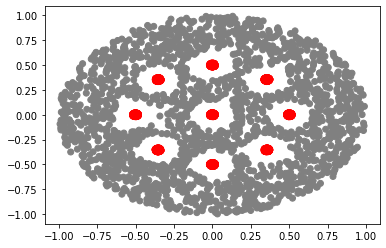

In [3]:
ds_holes = Topology2DHolesDataset(n_neg=2000,
                                  n_pos=2000,
                                  n_hole=9,
                                  r=1.,
                                  r_hole=.15,
                                  r_pos=.02,
                                  allow_center=True)

print(ds_holes.df.head(2))
plt.scatter(ds_holes.df.x1, ds_holes.df.x2, color=['red' if yi else 'gray' for yi in ds_holes.df.label])

### LINE SEGMENT DATASET¶

In [4]:
def get_line_segments_dataset(n_neg=10,
                              n_pos=10,
                              line_length=.1,
                              n_line_sample=30):
    """
    Generates line segments draw from two different manifolds
    
    Args
        n_neg: int
            How many negative examples to sample
            
        n_pos: int
            How many negative examples to sample       
    """
    n = n_neg + n_pos
    
    # This is where the line segments start
    start_x1 = 2 * np.random.random(n) - 1
    start_x2 = 2 * np.random.random(n) - 1
        
    rows = []
    line_ids = range(1, n + 1)
    labels = [0] * n_neg +  [1] * n_pos
    shuffle(labels)
    labels = np.array(labels)
    
    for line_id, label, x1, x2 in zip(line_ids, labels, start_x1, start_x2):
        
        # Angle
        theta = np.random.random() * 2 * np.pi
        
        for _ in range(n_line_sample):
            l = np.random.random() * line_length
        
            end_x1 = l * np.cos(theta) + x1
            end_x2 = l * np.sin(theta) + x2
        
            rows.append({'line_id': line_id,
                         'label': label,
                         'line_start_x1': x1,
                         'line_start_x2': x2,
                         'x1': end_x1,
                         'x2': end_x2})
    
    df = pd.DataFrame.from_dict(rows)
    return df

class LineSegmentDataset(Dataset):
    def __init__(self, n_neg=100,
                       n_pos=100,
                       line_length=.1,
                       n_line_sample=30):
        
        self.df = get_line_segments_dataset(n_neg=n_neg,
                                            n_pos=n_pos,
                                            line_length=line_length,
                                            n_line_sample=n_line_sample)
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = row[['x1', 'x2']].values.astype('float32')
        label = row.label.astype('long')
        return x, label

In [5]:
ds_lines = LineSegmentDataset(n_neg=5, n_pos=5, line_length=.2, n_line_sample=50)
print(f'Number of training examples: {ds_lines.df.shape[0]}')
ds_lines.df.head(2)

Number of training examples: 500


,line_id,label,line_start_x1,line_start_x2,x1,x2
0,1,0,-0.465889,0.420712,-0.356948,0.426739
1,1,0,-0.465889,0.420712,-0.340887,0.427628


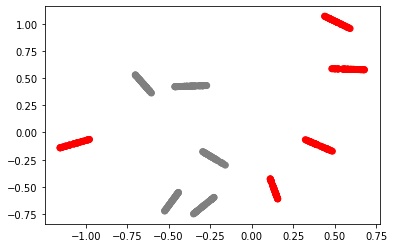

In [6]:
plt.scatter(ds_lines.df.x1, ds_lines.df.x2, color=['red' if yi else 'gray' for yi in ds_lines.df.label])

### Define the neural network 

In [7]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 2)
        
    def forward(self, x):
        return self.X2(x)
    
    def get_coordinates(self, x, layer=0):
        if layer == 0:
            return self.X0(x).detach().numpy()
        elif layer == 1:
            return self.X1(x).detach().numpy()
        elif layer == 2:
            return self.X2(x).detach().numpy()
        raise ValueError(f'Layer {layer} is not defined')
    
    def X0(self, x):
        return x
    
    def X1(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        return x
    
    def X2(self, x):
        x = self.X1(x)
        x = self.fc2(x)
        x = torch.relu(x)
        return x

### Setup training loop

<Figure size 432x288 with 0 Axes>

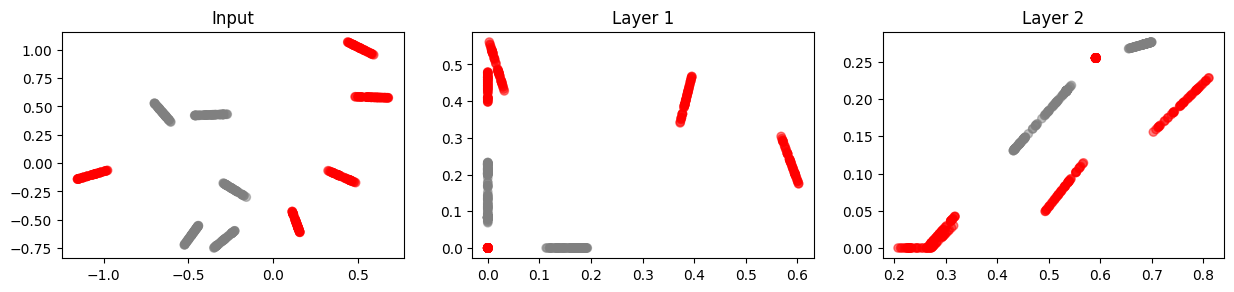

In [8]:
X = ds_lines.df[['x1', 'x2']].values
y = ds_lines.df.label.values

X_tensor = Tensor(X)
torch.manual_seed(8)
model = ANN()
n_layer = 3
trainloader = DataLoader(ds_lines, batch_size=64)

cost = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9)

color = ['red' if l else 'gray' for l in y]

plt.clf()
fig, ax = plt.subplots(1, n_layer, figsize=(15, 3), dpi=100)

for l in range(n_layer):
    title = f'Layer {l}' if l else 'Input'
  
    ax[l].set_title(title)
    
    Z = model.get_coordinates(X_tensor, l)
    ax[l].scatter(Z[:,0], Z[:,1], alpha=0.5,
              color=color)

^^ What the data looks like at each layer before we start training

In [9]:
from collections import defaultdict
n_epoch = 100

loss_t = []
n_steps = 0
epochs = list(range(n_epoch))

Xt = defaultdict(list)

for epoch in epochs:
    for X_batch, y_batch in trainloader:
        
        optimizer.zero_grad()
        
        y_hat = model(X_batch)
        loss = cost(y_hat, y_batch)
        loss.backward()
        
        optimizer.step()
        n_steps += 1
        
        loss_t.append(loss.item())

        # Record all coordinates
        for l in range(n_layer):
            Z = model.get_coordinates(X_tensor, l)
            Xt[l].append(Z)

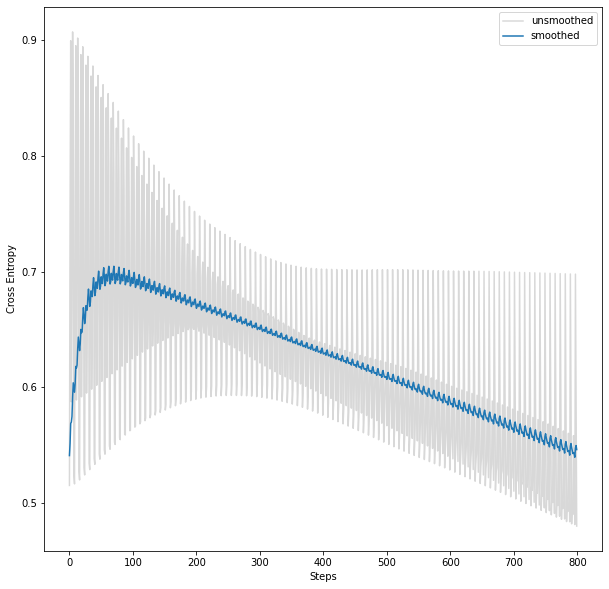

In [10]:
from scipy.signal import lfilter
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('Steps')
ax.set_ylabel('Cross Entropy')

# Exponential smoothing
alpha = .95
zi = [loss_t[0]]
y, zi = lfilter([1.-alpha], [1., -alpha], loss_t, zi=zi)

ax.plot(loss_t, label='unsmoothed', alpha=.3, color='gray')
ax.plot(y, label='smoothed')
ax.legend()

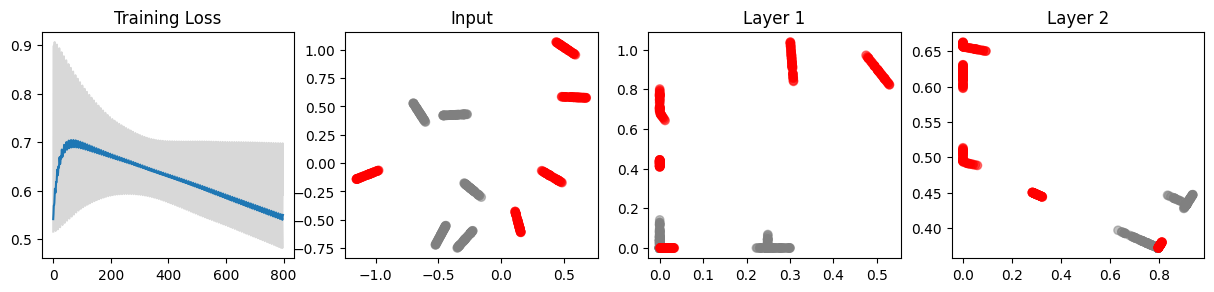

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(nrows=1,
                       ncols=n_layer + 1, # Add one col for loss
                       figsize=(15, 3), dpi=100)

ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Binary Cross Entropy')

for l in range(n_layer):
    Z = model.get_coordinates(X_tensor, l)
    
    ax[l + 1].set_title(f'Layer {l}' if l else 'Input')
    ax[l + 1].scatter(Z[:,0], Z[:,1], alpha=0.5, color=color)
    
def drawframe(n):
    
    ax[0].clear()
    ax[0].set_title('Training Loss')
    
    # Exponential smoothing
    alpha = .95
    zi = [loss_t[0]]
    
    y, zi = lfilter([1.-alpha], [1., -alpha], loss_t[:n], zi=zi)
    
    ax[0].plot(loss_t[:n], label='unsmoothed', alpha=.3, color='gray')
    ax[0].plot(y, label='smoothed')
    
    for l in range(n_layer):
        ax[l + 1].clear()
        ax[l + 1].set_title(f'Layer {l}' if l else 'Input')
        x = ax[l + 1].scatter(Xt[l][n][:,0], Xt[l][n][:,1], alpha=0.5,
                              color=color)
    return x,

anim = animation.FuncAnimation(fig, drawframe, frames=len(loss_t), interval=100, blit=True)

# You might need to `brew install ffmpeg` to get this to work
HTML(anim.to_html5_video())

In [12]:
# Save to disk
import os
with open(os.path.expanduser("~/Movies/ann.html"), "w") as f:
    print(anim.to_html5_video(), file=f)